# GMM PyTorch

## Setup

### Import Packages

In [423]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from typing import Union
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import entropy

### Set package parameters

In [424]:
plt.rcParams['figure.dpi'] =140
plt.rcParams['text.usetex']=True
np.random.seed(42)
torch.manual_seed(42)
rng = np.random.default_rng()

### Set Dataset Parameters

In [425]:
n_train = int(1e4) # size of training dataset (total)
n_test = int(1e4) # size of testing dataset (total)
pos_prior_train = 0.2 # proportion of training dataset that is class 1
pos_prior_test = pos_prior_train # proportion of testing dataset that is class 1
pos_mu = np.array([1,1]) # mean of positive class
neg_mu = np.array([-1,-1]) # mean of negative class
sigma = np.eye(2) # covariance matrix for each class

### Set Training Parameters

In [426]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
alpha_array = np.linspace(0.5, 20, 40)
lr = 1e-2
epochs = 2000
experiments = 20
noise_levels = [0.0,0.1, 0.2]
imbalance_levels = [0.5, 0.2]

## Function Definitions

In [427]:
def generate_gmm(
    n: int, 
    prior_pos: float,
    mu_pos: npt.ArrayLike,
    mu_neg: npt.ArrayLike,
    sigma_pos: npt.ArrayLike,
    sigma_neg: npt.ArrayLike = None,
    return_df: bool = False
) -> Union[tuple[np.ndarray, np.ndarray], pd.DataFrame]:
    # check to make sure sizes are compatible
    mu_pos = np.array(mu_pos)
    mu_neg = np.array(mu_neg)
    if mu_pos.shape != mu_neg.shape:
        raise ValueError('means must have the same shape')

    # check for equivariant case
    if sigma_neg is None: 
        sigma_neg=sigma_pos

    # size of each class
    n_pos = int(n * prior_pos)
    n_neg = n-n_pos

    # generate features
    x_pos = rng.multivariate_normal(mu_pos, sigma_pos, n_pos)
    x_neg = rng.multivariate_normal(mu_neg, sigma_neg, n_neg)

    # concatenate features and class labels
    x = np.vstack((x_pos, x_neg))
    y = np.vstack((np.ones((n_pos,1)), -np.ones((n_neg,1))))

    if not return_df:
        return x,y
    else:
        df = pd.DataFrame(data=np.hstack((x,y)),columns=[*['x_'+str(i) for i in range(len(mu_pos))], 'y'])
        return df

In [458]:
def sigmoid(z):
  a = 1 + np.exp(-z)
  return 1/a

In [428]:
def alpha_loss(output,target,alpha):
    torch_loss=0
    if alpha == 1.0:
        t1 = target * torch.log(output)
        t2 = -target * torch.log(1-output)
        torch_loss = torch.mean(-(t1 + t2))
    else:
        pow = 1-(1/alpha)
        sig_power_1 = torch.pow(output, pow)
        sig_power_2 = torch.pow(1-output, pow)       
        torch_loss = (alpha/(alpha-1))*(1 - target*sig_power_1 + target*sig_power_2)
    return torch.mean(torch_loss)

In [429]:
def alpha_loss_calc_torch(X_tensor, y_tensor, theta_1, theta_2, theta_3, alpha):

    X_tensor_1 = X_tensor[:,0]
    X_tensor_2 = X_tensor[:,1]
    X_tensor_1 = X_tensor_1.view(X_tensor_1.size(0),1)
    X_tensor_2 = X_tensor_2.view(X_tensor_2.size(0),1)

    X_T_theta = theta_1 + theta_2*X_tensor_1 + theta_3*X_tensor_2

    sig_tensor = (torch.special.expit(X_T_theta))

    if alpha == 1:
        t1 = y_tensor * torch.log(sig_tensor)
        t2 = (1-y_tensor) * torch.log(1-sig_tensor)
        torch_loss = torch.mean(-(t1 + t2))

    else:
        pow = 1-(1/alpha)
        sig_power_1 = torch.pow(sig_tensor, pow)
        sig_power_2 = torch.pow(1-sig_tensor, pow)       
        torch_loss = (alpha/(alpha-1))*(1 - y_tensor*sig_power_1 - (1-y_tensor)*sig_power_2)

    # with torch.no_grad():
    #     mean_loss = torch.mean(loss)

    # mean_loss = torch.mean(loss)
    mean_loss = torch.mean(torch_loss)
    return mean_loss

In [430]:
def posterior(
    x: npt.ArrayLike,
    prior_pos: float,
    mu_pos: npt.ArrayLike,
    mu_neg: npt.ArrayLike,
    sigma_pos: npt.ArrayLike,
    sigma_neg: npt.ArrayLike = None
) -> npt.ArrayLike:
    if sigma_neg is None:
        sigma_neg=sigma_pos
    return prior_pos * mnorm.pdf(x, mean=mu_pos, cov = sigma_pos) / (prior_pos * mnorm.pdf(x, mean=mu_pos, cov = sigma_pos) + (1-prior_pos)*mnorm.pdf(x,mean=mu_neg, cov = sigma_neg))

In [431]:
def alpha_tilted_posterior(
    x: npt.ArrayLike,
    alpha: float, 
    p_flip: float, 
    prior_pos: float, 
    mu_pos: npt.ArrayLike, 
    mu_neg: npt.ArrayLike, 
    sigma_pos: npt.ArrayLike,
    sigma_neg: npt.ArrayLike = None
) -> npt.ArrayLike:
    if sigma_neg is None:
        sigma_neg=sigma_pos
    clean_posterior = posterior(x,prior_pos, mu_pos, mu_neg, sigma_pos)
    twisted_posterior = p_flip*(1-clean_posterior) + (1-p_flip)*clean_posterior
    return np.power(twisted_posterior,alpha) / (np.power(twisted_posterior,alpha) + np.power(1-twisted_posterior,alpha))

In [432]:
def add_label_noise(
    p: float,
    dataset: pd.DataFrame = None,
    x: np.ndarray = None,
    y: np.ndarray = None,
    symmetric: bool = True
) -> Union[pd.DataFrame, tuple[np.ndarray, np.ndarray]]:
    if symmetric:
        if dataset is not None:
            n=len(dataset)
            nflip = int(p*n/2)
            flip_array_pos = rng.choice(dataset[dataset.y==1].index, nflip, replace=False)
            flip_array_neg = rng.choice(dataset[dataset.y==-1].index, nflip, replace=False)
            twisted_dataset = dataset.copy()
            twisted_dataset.iloc[flip_array_pos] *= -1
            twisted_dataset.iloc[flip_array_neg] *= -1
            return twisted_dataset
        elif x is not None and y is not None:
            n = len(x)
            nflip = int(p*n/2)
            n_mix = len(y[y==1])
            flip_array_pos=rng.choice(n_mix, nflip, replace=False)
            flip_array_neg=rng.choice(np.arange(n_mix, n), nflip, replace=False)
            twisted_y = y.copy()
            twisted_y[flip_array_pos] *= -1
            twisted_y[flip_array_neg] *= -1
            return x, twisted_y 
        else:
            raise ValueError('must provide either dataset or x and y parameters')
    else:
        raise NotImplementedError()

In [433]:
def change_to_0_1(y):
    return (y + 1)/2

## Train

In [438]:
theta_df = pd.DataFrame(columns=['alpha','noise','imbalance', *['theta_'+str(i) for i in range(3)]])
for (noise,imbalance) in [(n,i) for n in noise_levels for i in imbalance_levels]:
    x,y = generate_gmm(n_train, imbalance, pos_mu, neg_mu, sigma, return_df=False)
    x,y = add_label_noise(noise, x=x, y=y)
    y = change_to_0_1(y)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    for alpha in alpha_array:
        for exp in range(experiments):
            alpha_tensor = torch.tensor(alpha, requires_grad=False, dtype=torch.float, device=device)
            theta_init = rng.random(3)
            theta_1 = torch.tensor(theta_init[0],requires_grad=True, dtype=torch.float, device=device)
            theta_2 = torch.tensor(theta_init[1],requires_grad=True, dtype=torch.float, device=device)
            theta_3 = torch.tensor(theta_init[2],requires_grad=True, dtype=torch.float, device=device)    
            theta = [theta_1, theta_2, theta_3]
            optimizer = optim.SGD(theta, lr=lr)
            for epoch in range(epochs):
                optimizer.zero_grad()
                loss = alpha_loss_calc_torch(x, y, theta[0], theta[1], theta[2], alpha_tensor)
                loss.backward()
                optimizer.step()
            theta = [theta_1.item(), theta_2.item(), theta_3.item()]
            theta_df.loc[len(theta_df)] = [alpha,noise,imbalance, *theta]
            print(alpha, noise, imbalance, theta)

0.5 0.0 0.5 [0.0029529917519539595, 0.9969421029090881, 1.0562243461608887]
0.5 0.0 0.5 [0.003126472234725952, 0.9968816637992859, 1.0558663606643677]
0.5 0.0 0.5 [0.003271091263741255, 0.9969817399978638, 1.0558664798736572]
0.5 0.0 0.5 [0.0030325811821967363, 0.9971081018447876, 1.056104063987732]
0.5 0.0 0.5 [0.0037218942306935787, 0.9973878860473633, 1.055661916732788]
0.5 0.0 0.5 [0.003481544554233551, 0.9973360896110535, 1.056204915046692]
0.5 0.0 0.5 [0.003526229178532958, 0.9971850514411926, 1.0556138753890991]
0.5 0.0 0.5 [0.0031154996249824762, 0.9969519376754761, 1.0558024644851685]
0.5 0.0 0.5 [0.003116094972938299, 0.9969125390052795, 1.0557124614715576]
0.5 0.0 0.5 [0.00352176814340055, 0.9972776770591736, 1.0560929775238037]
0.5 0.0 0.5 [0.0035624669399112463, 0.9972048997879028, 1.055825114250183]
0.5 0.0 0.5 [0.003416634164750576, 0.9970914721488953, 1.056001901626587]
0.5 0.0 0.5 [0.0028919889591634274, 0.9968429803848267, 1.0562206506729126]
0.5 0.0 0.5 [0.0035372439

      alpha  noise  imbalance   theta_0   theta_1   theta_2       mse  \
0       0.5    0.0        0.5  0.002953  0.996942  1.056224  0.796994   
1       0.5    0.0        0.5  0.003126  0.996882  1.055866  0.797341   
2       0.5    0.0        0.5  0.003271  0.996982  1.055866  0.797341   
3       0.5    0.0        0.5  0.003033  0.997108  1.056104  0.796996   
4       0.5    0.0        0.5  0.003722  0.997388  1.055662  0.797410   
...     ...    ...        ...       ...       ...       ...       ...   
4795   20.0    0.2        0.2 -1.195389  1.002948  1.023004  0.731348   
4796   20.0    0.2        0.2 -1.014245  0.995696  1.297947  0.533418   
4797   20.0    0.2        0.2 -0.670293  1.271863  1.381832  0.304399   
4798   20.0    0.2        0.2 -0.934029  1.265660  1.043380  0.503049   
4799   20.0    0.2        0.2 -1.064838  1.038613  1.292917  0.519113   

            kl  
0     0.045045  
1     0.045071  
2     0.045065  
3     0.045042  
4     0.045051  
...        ...  
4795

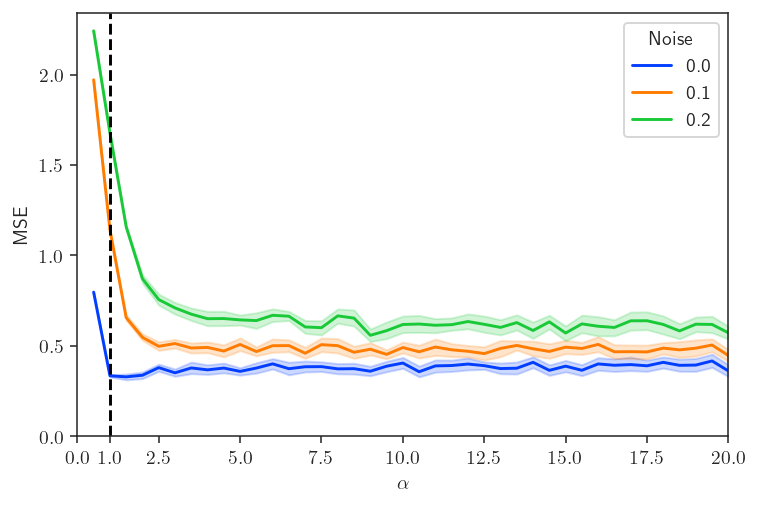

In [512]:
theta_df['mse'] = (theta_df[['theta_'+str(i) for i in range(3)]] - [-0.7,2,2]).pow(2).mean(axis=1)
print(theta_df)
sns.lineplot(x='alpha', y ='mse' , hue='noise',data=theta_df[theta_df.imbalance==0.5],palette='bright')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'MSE')
plt.legend(title='Noise')
plt.axvline(x=1, linestyle='dashed', color='black')
plt.xlim((0,20))
plt.ylim(bottom=0)
plt.xticks(list(plt.xticks()[0]) + [1.0])
plt.savefig('balanced_mse_ci.png', dpi=1000)

In [489]:
theta_df.to_pickle('theta.pkl')

In [484]:
for imbalance in imbalance_levels:
    x_test, y_test = generate_gmm(n_test, imbalance, pos_mu, neg_mu, sigma)
    for noise in noise_levels:
        thetas = theta_df[(theta_df.noise == noise) & (theta_df.imbalance==imbalance)][['theta_0','theta_1','theta_2']]
        logit = thetas[['theta_1','theta_2']].to_numpy() @x_test.T+ thetas['theta_0'].to_numpy()[:,np.newaxis]
        alpha_posterior = sigmoid(logit)
        clean_posterior = posterior(x_test, imbalance, pos_mu, neg_mu, sigma)[:,np.newaxis]
        kl = (entropy([clean_posterior, 1-clean_posterior],[alpha_posterior.T, 1-alpha_posterior.T], axis=0).mean(axis=0))
        print(imbalance, noise, kl.shape)
        theta_df.loc[(theta_df.noise == noise) & (theta_df.imbalance==imbalance),'kl'] = kl


0.5 0.0 (800,)
0.5 0.1 (800,)
0.5 0.2 (800,)
0.2 0.0 (800,)
0.2 0.1 (800,)
0.2 0.2 (800,)


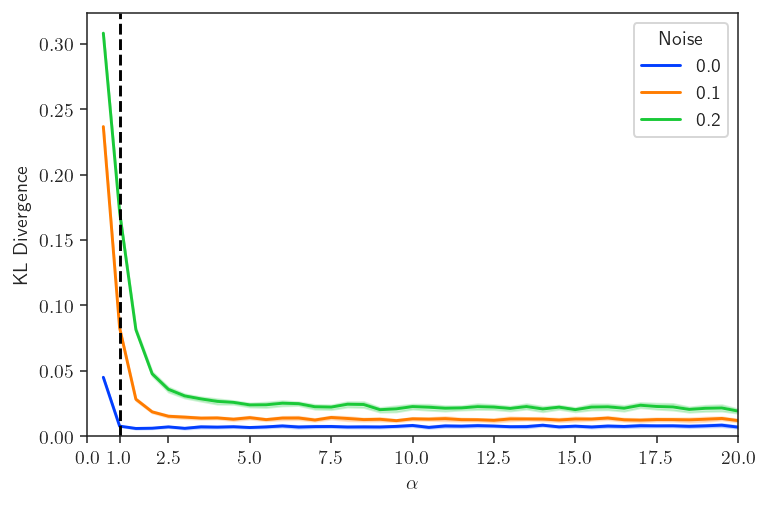

In [508]:
sns.lineplot(data=theta_df[theta_df.imbalance==0.5], x='alpha',y='kl', hue='noise', palette='bright')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'KL Divergence')
plt.legend(title='Noise')
plt.axvline(x=1, linestyle='dashed', color='black')
plt.xlim((0,20))
plt.ylim(bottom=0)
plt.xticks(list(plt.xticks()[0]) + [1.0])
plt.savefig('balanced_kl_ci.png', dpi=1000)